![](https://images.aicrowd.com/raw_images/challenges/banner_file/1021/e6d6bda6dc16f4905124.png)

<h2><center>Starter Code for Face Recognition</center></h2>


In this baseline we will be using basic [Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error)
 to compare the missing person image to all target faces ans generate our predictions. 

## Downloading Dataset

Installing puzzle datasets via `aicrowd-cli`

In [1]:
!pip install aicrowd-cli

# Make sure to re-run below code whenever you restart colab notebook

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


# Uncomment and run this cell to prepare data
!rm -rf data
!mkdir data
%aicrowd ds dl -c face-recognition -o data
%%bash
cd data
unzip data.zip
!unzip data/data.zip -d data > /dev/null

In [3]:
!ls data/

data.zip  missing  sample_submission.csv  target


## Importing Libraries

In [4]:
import pandas as pd
import os
import numpy as np
import random
from tqdm.notebook import tqdm
import cv2
import torch

random.seed(42)

from backbones import iresnet
import torch

## Reading Dataset

In [8]:
# Getting all image ids from a folder

image_ids = os.listdir("data/missing")
len(image_ids)

1000

In [9]:
!ls data/

data.zip  missing  sample_submission.csv  target


In [10]:
import matplotlib.pyplot as plt

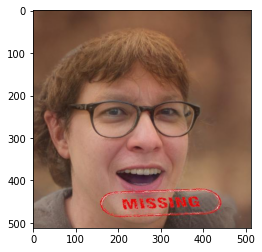

In [12]:
# Reading a sample missing person image


sample_image_id = random.choice(image_ids)
sample_image_id = '7kuz4.jpg'

sample_missing = cv2.imread(os.path.join("data/missing", sample_image_id))[:,:,[2,1,0]]
plt.imshow(sample_missing)

In [13]:
from skimage import filters

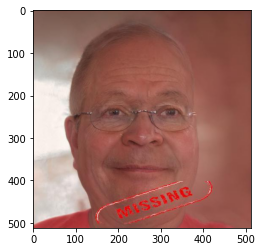

In [14]:
sample_image_id = '7kuz4.jpg'

sample_missing = cv2.imread(os.path.join("data/missing", image_ids[20]))[:,:,[2,1,0]]
plt.imshow(sample_missing)

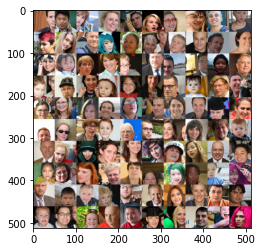

In [17]:
# Reading the corrosponding target faces

sample_target = cv2.imread(os.path.join("data/target", sample_image_id)) [:,:,[2,1,0]]
plt.imshow(cv2.resize(sample_target, (512, 512)))

In [20]:
from PIL import Image

In [21]:
type(Image.fromarray(sample_target_face))

PIL.Image.Image

In [22]:
from mlutil.feature_extraction import images as image_feature_extraction

In [23]:
from torchvision import models
import torch
from torch import nn
from torchvision import transforms
from PIL import Image
from torchvision import datasets
from sklearn import metrics
from skimage import util
from PIL import Image
from skimage import data
from skimage.feature import Cascade
from facenet_pytorch import MTCNN, InceptionResnetV1

from torch.utils import data

import matplotlib.pyplot as plt
from matplotlib import patches

import skimage.io
from torch.utils import data

# General approach

Our approach heavily uses `facenet_pytorch` library.

First we extract face crop using MTCNN model for face detection.

Then we compare missing image crops with cropped target faces.

In [25]:
mtcnn = MTCNN()

model = InceptionResnetV1(pretrained='vggface2').eval()

In [176]:
model.cuda().half();

In [70]:
image_vectorizer = image_feature_extraction.TorchFeatureExtractor(
    model,
    appended_modules=[nn.Flatten()],
    last_layer_index=None, use_gpu=True, to_fp16=False, last_nested_layer_index=None, img_size=160)

In [129]:
target_image = skimage.io.imread(os.path.join("data/missing/", image_ids[0]))

In [134]:
def make_viewable_image_tensor(img_tensor):
    
    missing_img_nd = (img_tensor - img_tensor.min()) / (img_tensor.max() - img_tensor.min())
    return missing_img_nd.cpu().numpy().transpose([1,2,0])

# Example image cropped by MTCNN

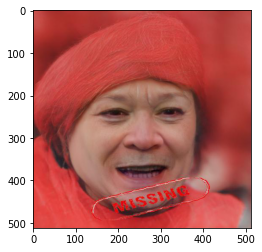

In [133]:
plt.imshow(target_image)

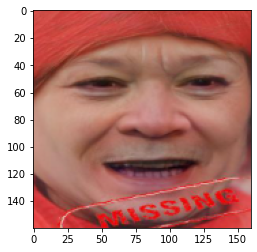

In [131]:
plt.imshow(make_viewable_image_tensor(mtcnn(target_image)))

# Prepare images for loading into model

This is a single function because preprocessing is the longest step in our pipeline. 

In [60]:
def get_missing_and_target_crops(image_ids, do_crop=True):
    missing_images_cropped = []
    target_images_cropped = []
    for img_id in tqdm(image_ids):
        raw_missing_image = skimage.io.imread(os.path.join("data/missing", img_id))#) * 255).astype('uint8')
        if do_crop:
            missing_image = mtcnn(raw_missing_image)
            if missing_image is None:
                image_is_cropped = False#missing_image.mean() != raw_missing_image.mean()
            else:
                image_is_cropped = True
        else:
            image_is_cropped = False 
            missing_image = raw_missing_image

        target_image = skimage.io.imread(os.path.join("data/target", img_id))
        raw_imgs = [img for img in util.view_as_blocks(target_image, (216, 216, 3)).reshape(100, 216, 216, 3)]
        mtcnn_imgs = [mtcnn(img) for img in raw_imgs]
        imgs = [
            mtcnn_img.cpu().unsqueeze(0) if mtcnn_img is not None and image_is_cropped else image_vectorizer.process_img(img).cpu()
            for (mtcnn_img, img) in zip(mtcnn_imgs, raw_imgs)
        ]
        torch_imgs = torch.cat([img for img in imgs])

        missing_images_cropped.append(missing_image)
        target_images_cropped.append(torch_imgs.cpu())
    return missing_images_cropped, target_images_cropped

In [61]:
missing_images_cropped, target_images_cropped = get_missing_and_target_crops(image_ids)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [62]:
len(image_ids)

1000

In [135]:
len(target_images_cropped)

1000

# Recognizing faces

We use standard methodology for information retrieval and in particular face recognition/reidentification.

For each extracted face crop we calculate embeddings using our model, and then compare embeddings using cosine similarity or Euclidean distance.

In [91]:
def get_predictions(image_ids, missing_images_cropped, target_images_cropped, metric='cosine'):
    predictions = {"ImageID":[], "target":[]}

    for img_id, missing_image, torch_imgs in tqdm(zip(image_ids, missing_images_cropped, target_images_cropped), total=len(missing_images_cropped)): 
        if missing_image is None:
            raw_missing_image = (skimage.io.imread(os.path.join("data/missing", img_id)))# * 255).astype('uint8')
            missing_image = image_vectorizer.process_img(raw_missing_image)[0]
        missing_image_vector = model(missing_image.unsqueeze(0).cuda().half()).detach().cpu().numpy()
        missing_image_vector = missing_image_vector.reshape(missing_image_vector.shape[:2])

        target_vectors = model(torch_imgs.cuda().half()).detach().cpu().numpy()
        target_vectors = target_vectors.reshape(target_vectors.shape[:2])
        similarities = metrics.pairwise_distances(missing_image_vector, target_vectors, metric=metric)[0]
        closest_face_no = similarities.argmin()

        predictions['ImageID'].append(img_id.replace(".jpg", ""))
        predictions['target'].append(closest_face_no)
    return pd.DataFrame(predictions)

In [112]:
submission = get_predictions(image_ids, missing_images_cropped, target_images_cropped, metric='cosine')

  0%|          | 0/1000 [00:00<?, ?it/s]

   original                     retrieved


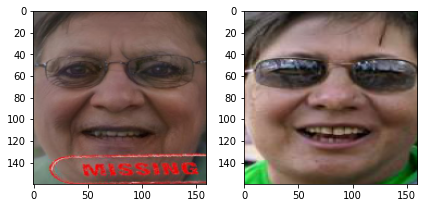

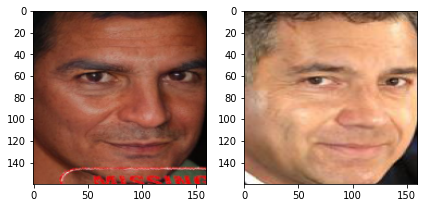

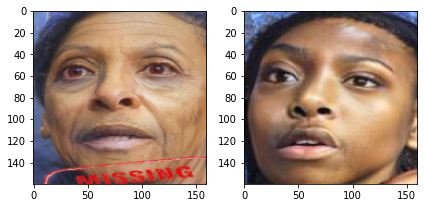

In [175]:
print("   original                     retrieved")
for i in [2, 15, 502]:
    fig = plt.figure()
    ax_dict = fig.subplot_mosaic([["original", "retrieved"]])
    ax_dict['original'].imshow(make_viewable_image_tensor(missing_images_cropped[i]))
    found_target_img = target_images_cropped[i][submission['target'][i]]
    ax_dict['retrieved'].imshow(make_viewable_image_tensor(found_target_img))
    fig.tight_layout()

### Saving the Predictions

# Logging in from our AIcrowd account. Make sure you have accepted the puzzle rules before logging in!  


%load_ext aicrowd.magic
%aicrowd login

In [118]:
# Saving the predictions
!rm -rf submission/assets
!mkdir -p submission/assets
submission.to_csv(os.path.join("submission", "assets", "submission.csv"), index=False)

In [119]:
%%bash
pushd submission
rm submission.zip
cp ../Face_Recognition_Facenet.ipynb notebook.ipynb
zip -r submission.zip *
popd

~/Projects/aicrowd/blitzxiii/face_recognition/submission ~/Projects/aicrowd/blitzxiii/face_recognition
  adding: assets/ (stored 0%)
  adding: assets/submission.csv (deflated 38%)
  adding: notebook.ipynb (deflated 31%)
~/Projects/aicrowd/blitzxiii/face_recognition


cp: cannot stat '../baseline-face-recognition-dc9e45f8-3e3f-4040-886b-b6482fa98245.ipynb': No such file or directory


In [178]:
!aicrowd submission create -c face-recognition -f submission/submission.zip

submission.zip ━━━━━━━━━━━━━━━━━━━━ 100.0% • 712.4/710.7 KB • 4.1 MB/s • 0:00:00 • 0:00:010:00:01
                                                   ╭─────────────────────────╮                                                   
                                                   │ Successfully submitted! │                                                   
                                                   ╰─────────────────────────╯                                                   
                                                         Important links                                                         
┌──────────────────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│  This submission │ https://www.aicrowd.com/challenges/ai-blitz-xiii/problems/face-recognition/submissions/175686              │
│                  │                                                                                                      